<h1>ImageDataGenerator untuk mengatasi ukuran gambar yang berbeda

In [1]:
#kita gunakan dataset chessman yang disediakan oleh dicoding
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip \
    -O /tmp/Chessman-image-dataset.zip

--2022-11-15 15:31:20--  https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip [following]
--2022-11-15 15:31:20--  https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60684125 (58M) [application/zip]
Saving to: ‘/tmp/Chessman-image-dataset.zip’

/tmp/Chessman-image 100%[===================>]  57.87M   299MB/s   

ektrak dataset yang sudah diunduh karena masih dalam bentuk file zip

In [2]:
import os
import zipfile
local_zip = '/tmp/Chessman-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Gunakan fungsi listdir dari kelas os untuk melihat direktori yang terdapat pada dataset.

In [3]:
os.listdir('/tmp/Chessman-image-dataset/Chess')

['Bishop', 'Queen', 'Knight', 'Rook', 'King', 'Pawn']

Selanjutnya kita perlu melihat berapa banyak gambar pada setiap direktori. Dari output dapat dilihat bahwa jumlah sampel pada tiap direktori berbeda. Perlu diperhatikan juga dataset ini berukuran sangat kecil sehingga performa dari model mungkin tidak akan terlalu baik. Kita akan mencoba menggunakan augmentasi gambar untuk mengatasi masalah ini.

In [4]:
print('total pawn images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Pawn')))
print('total King images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/King')))
print('total Knight images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Knight')))

total pawn images : 107
total King images : 76
total Knight images : 106


Kita dapat melihat contoh dari sebuah gambar pada dataset dengan menjalankan kode di bawah.

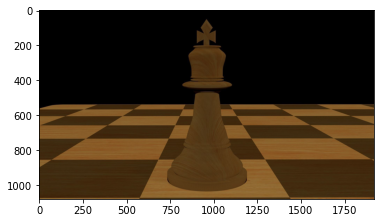

In [5]:
from keras.preprocessing import image #this library not work, so I use tf to load image
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img = load_img('/tmp/Chessman-image-dataset/Chess/King/00000145.png')
imgplot = plt.imshow(img)

Selanjutnya kita impor ImageDataGenerator dan aplikasikan augmentasi gambar pada dataset kita. Perhatikan bahwa ada parameter yaitu validation split. Parameter ini akan dijelaskan pada paragraf berikutnya.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
 
train_dir = os.path.join('/tmp/Chessman-image-dataset/Chess')
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode = 'nearest',
    validation_split=0.1) # set validation split

Dataset yang kita miliki hanya terdiri dari 1 buah direktori dan tidak terbagi menjadi direktori training dan testing. Tapi tenang, dengan ImageDataGenerator kita tidak perlu susah payah membagi direktori secara manual, cukup dengan menggunakan parameter validation_split yang disebut pada paragraf sebelumnya. Dengan parameter tersebut, kita hanya cukup memberi tahu ImageDataGenerator mana data untuk training dan mana data untuk testing dengan menambahkan parameter subset dengan nilai training atau validation.

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 499 images belonging to 6 classes.
Found 52 images belonging to 6 classes.


Selanjutnya, kita buat arsitektur dari model kita. Untuk model ini kita menggunakan 3 lapis convolution dan 2 hidden layer dengan 512 dan 256 buah unit perseptron.

In [8]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  
])

Setelah arsitektur dibuat, tentukan optimizer dan loss yang akan digunakan model

In [9]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Terakhir, panggil fungsi fit untuk melatih model kita.

In [10]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=50,
                              verbose=2)

Epoch 1/50
63/63 - 19s - loss: 1.8937 - accuracy: 0.1784 - val_loss: 1.7870 - val_accuracy: 0.2308 - 19s/epoch - 302ms/step
Epoch 2/50
63/63 - 10s - loss: 1.7878 - accuracy: 0.2004 - val_loss: 1.7849 - val_accuracy: 0.2308 - 10s/epoch - 154ms/step
Epoch 3/50
63/63 - 9s - loss: 1.7817 - accuracy: 0.1944 - val_loss: 1.7647 - val_accuracy: 0.2500 - 9s/epoch - 145ms/step
Epoch 4/50
63/63 - 10s - loss: 1.7559 - accuracy: 0.2084 - val_loss: 1.7455 - val_accuracy: 0.2692 - 10s/epoch - 160ms/step
Epoch 5/50
63/63 - 9s - loss: 1.7295 - accuracy: 0.2465 - val_loss: 1.7620 - val_accuracy: 0.2692 - 9s/epoch - 145ms/step
Epoch 6/50
63/63 - 10s - loss: 1.6981 - accuracy: 0.2926 - val_loss: 1.7136 - val_accuracy: 0.2308 - 10s/epoch - 154ms/step
Epoch 7/50
63/63 - 9s - loss: 1.6796 - accuracy: 0.3066 - val_loss: 1.6482 - val_accuracy: 0.3077 - 9s/epoch - 145ms/step
Epoch 8/50
63/63 - 9s - loss: 1.6508 - accuracy: 0.3106 - val_loss: 1.7989 - val_accuracy: 0.2500 - 9s/epoch - 144ms/step
Epoch 9/50
63/63

Anda juga dapat membuat plot akurasi dari model menggunakan kode berikut.

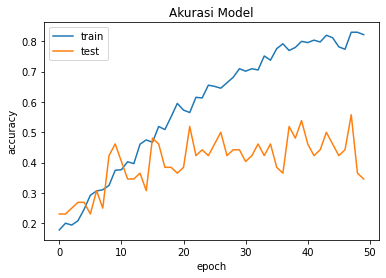

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Untuk membuat plot loss Anda cukup menjalankan kode berikut.

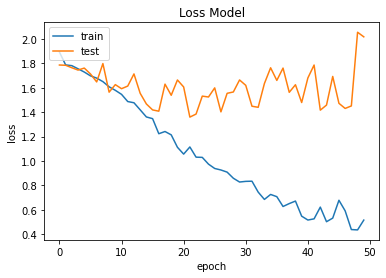

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Selamat, Anda berhasil mengembangkan model untuk mengklasifikasikan dataset yang sangat variatif. Akurasi yang didapat sekitar 50% di mana model akan membuat sekitar 50 persen prediksi yang salah.

Setelah ini, saya akan menggunakan transfer learning dan melihat bagaimana teknik ini meningkatkan akurasi dari model ini.